# VGG-18 CNN: PyTorch & CIFAR-10

End-to-end programming tutorial including:

1. Progress bar - training model
2. Train model with _early stopping criterion_
3. Learning rate scheduler
4. Compare between learning rate scheduler and early stopping criterion

## References
https://github.com/arjun-majumdar/CNN_Classifications/blob/master/VGG18_Dropout_PyTorch.ipynb  
https://github.com/arjun-majumdar/CNN_Classifications 




In [1]:
### Specify GPU to be used-
##%env CUDA_DEVICE_ORDER=PCI_BUS_ID
##%env CUDA_VISIBLE_DEVICES = 2

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms


from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"currently available device: {device}")

currently available device: cuda


In [5]:
print(f"PyTorch version: {torch.__version__}")

PyTorch version: 1.10.0


In [44]:
# Hyper-parameters-
num_epochs = 2 #65
batch_size = 128
learning_rate = 0.01

In [45]:
# Define transformations for training and test sets-
transform_train = transforms.Compose(
    [
      transforms.RandomCrop(32, padding = 4),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
     ]
     )

transform_test = transforms.Compose(
    [
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
     ]
     )

In [46]:
# Load dataset-
train_dataset = torchvision.datasets.CIFAR10(
        root = '../data', train = True,
        download = True, transform = transform_train
        )

test_dataset = torchvision.datasets.CIFAR10(
        root = '../data', train = False,
        download = True, transform = transform_test
        )

Files already downloaded and verified
Files already downloaded and verified


In [47]:
# Create training and testing loaders-
train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size = batch_size,
        shuffle = True
        )

test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size = batch_size,
        shuffle = False
        )

In [48]:
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader) = 391 & len(test_loader) = 79


In [49]:
# Sanity check-
len(train_dataset) / batch_size, len(test_dataset) / batch_size

(390.625, 78.125)

In [50]:
# Sanity check-
len(train_dataset) / batch_size, len(test_dataset) / batch_size

# Sanity check-
images, labels = next(iter(train_loader))

images.size(), labels.shape

(torch.Size([128, 3, 32, 32]), torch.Size([128]))

In [51]:
#del images, labels

### Define _VGG_ architecture:

In [52]:
class VGGBlock(nn.Module):
    '''
    VGG block within a VGG-* CNN model
    '''
    def __init__(self, input_channels, num_channels, padding_size = 1,
                 stride_size = 1, use_extra_conv = False, dropout = 0.2):
        super().__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels = input_channels, out_channels = num_channels,
            kernel_size = 3, padding = padding_size,
            stride = stride_size, bias = False
        )
        
        self.dropout = nn.Dropout(p = dropout)
        
        self.conv2 = nn.Conv2d(
            in_channels = num_channels, out_channels = num_channels,
            kernel_size = 3, padding = padding_size,
            stride = stride_size, bias = False
        )
        
        if use_extra_conv:
            self.conv3 = nn.Conv2d(
                in_channels = num_channels, out_channels = num_channels,
                kernel_size = 3, padding = padding_size,
                stride = stride_size, bias = False
            )
            
            self.conv4 = nn.Conv2d(
                in_channels = num_channels, out_channels = num_channels,
                kernel_size = 3, padding = padding_size,
                stride = stride_size, bias = False
            )
        else:
            self.conv3 = False
            self.conv4 = False
        
        self.pool = nn.MaxPool2d(
            kernel_size = 2, stride = 2)
            # padding = 1)
        
        self.bn1 = nn.BatchNorm2d(num_features = num_channels)
        self.bn2 = nn.BatchNorm2d(num_features = num_channels)

        if use_extra_conv:
            self.bn3 = nn.BatchNorm2d(num_features = num_channels)
            self.bn4 = nn.BatchNorm2d(num_features = num_channels)
        
        self.initialize_weights()
    
    
    def forward(self, X):
        Y = self.dropout(F.relu(self.bn1(self.conv1(X))))
        Y = self.dropout(F.relu(self.bn2(self.conv2(Y))))
        
        if self.conv3 and self.conv4:
            Y = self.dropout(F.relu(self.bn3(self.conv3(Y))))
            Y = self.dropout(F.relu(self.bn4(self.conv4(Y))))
            Y = self.pool(Y)
        else:
            Y = self.pool(Y)
        
        return Y
    
    
    def shape_computation(self, X):
        Y = self.bn1(self.conv1(X))
        print(f"self.bn(conv1(X)).shape: {Y.shape}")
        
        Y = self.bn2(self.conv2(Y))
        print(f"self.bn(conv2(Y)).shape: {Y.shape}")
        
        if self.conv3 and self.conv4:
            Y = self.bn3(self.conv3(Y))
            print(f"self.bn(conv3(Y)).shape: {Y.shape}")
            
            Y = self.bn4(self.conv4(Y))
            print(f"self.bn(conv4(Y)).shape: {Y.shape}")
            
            Y = self.pool(Y)
            print(f"self.pool(Y).shape: {Y.shape}")
        else:
            Y = self.pool(Y)
            print(f"self.pool(Y).shape: {Y.shape}")
        

    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight)

                '''
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                '''
            
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)


In [53]:
class VGG18(nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = VGGBlock(input_channels = 3, num_channels = 64, dropout = 0)
        self.block2 = VGGBlock(input_channels = 64, num_channels = 128)
        self.block3 = VGGBlock(input_channels = 128, num_channels = 256,
                use_extra_conv = True, dropout = 0.3)
        self.block4 = VGGBlock(input_channels = 256, num_channels = 512,
                use_extra_conv = True, dropout = 0.3)
        self.block5 = VGGBlock(input_channels = 512, num_channels = 512,
                use_extra_conv = True, dropout = 0.3)

        # self.pool = nn.MaxPool2d(kernel_size = 1, stride = 1)
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(in_features = 512, out_features = 256)
        self.dense2 = nn.Linear(in_features = 512, out_features = 10)
        
        self.dropout = nn.Dropout(p = 0.3)


    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        # x = self.pool(x)
        # print(f"After block5, x.shape: {x.shape}")
        # After block5, x.shape: torch.Size([128, 512, 1, 1]) 
        # x = torch.flatten(x)
        x = self.flatten(x)
        # print(f"After flattening, x.shape: {x.shape}")
        # After flattening, x.shape: torch.Size([128, 512]) 
        x = F.relu(self.dropout(self.dense1(x)))
        x = F.relu(self.dense2(x))
        return x


In [54]:
# model = VGG18()
# model.to(device)

In [55]:
# images = images.to(device)

In [56]:
# Sanity check-
# model(images).shape

In [57]:
# Initialize VGG-18 CNN model-
model = nn.Sequential(
    VGGBlock(input_channels = 3, num_channels = 64, dropout = 0.0),
    VGGBlock(input_channels = 64, num_channels = 128, dropout = 0.2),
    VGGBlock(input_channels = 128, num_channels = 256, use_extra_conv = True, dropout = 0.3),
    VGGBlock(input_channels = 256, num_channels = 512, use_extra_conv = True, dropout = 0.3),
    VGGBlock(input_channels = 512, num_channels = 512, use_extra_conv = True, dropout = 0.3),
    nn.Flatten(),
    nn.Linear(in_features = 512, out_features = 256),
    nn.Dropout(p = 0.3),
    nn.ReLU(),
    nn.Linear(in_features = 256, out_features = 10)
    )


In [58]:
# Place model on GPU-
model.to(device)

Sequential(
  (0): VGGBlock(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (dropout): Dropout(p=0.0, inplace=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): VGGBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (dropout): Dropout(p=0.2, inplace=False)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(128, eps=1e-05, momentu

In [59]:
images = images.to(device)

In [60]:
# Sanity check-
model(images).shape

torch.Size([128, 10])

In [61]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

layer.shape = torch.Size([64, 3, 3, 3]) has 1728 parameters
layer.shape = torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([128, 64, 3, 3]) has 73728 parameters
layer.shape = torch.Size([128, 128, 3, 3]) has 147456 parameters
layer.shape = torch.Size([128]) has 128 parameters
layer.shape = torch.Size([128]) has 128 parameters
layer.shape = torch.Size([128]) has 128 parameters
layer.shape = torch.Size([128]) has 128 parameters
layer.shape = torch.Size([256, 128, 3, 3]) has 294912 parameters
layer.shape = torch.Size([256, 256, 3, 3]) has 589824 parameters
layer.shape = torch.Size([256, 256, 3, 3]) has 589824 parameters
layer.shape = torch.Size([256, 256, 3, 3]) has 589824 parameters
layer.shape = torch.Size([256]) has 256 parameters
layer.shape = torch.Size([256]) has 256

In [62]:
print(f"Total number of parameters in VGG-18 CNN = {tot_params}")

Total number of parameters in VGG-18 CNN = 20163786


In [63]:
#'''
# Print layer names-
for layer in model.state_dict().keys():
    print(f"{layer} has dimension = {model.state_dict()[layer].shape}")
#'''

0.conv1.weight has dimension = torch.Size([64, 3, 3, 3])
0.conv2.weight has dimension = torch.Size([64, 64, 3, 3])
0.bn1.weight has dimension = torch.Size([64])
0.bn1.bias has dimension = torch.Size([64])
0.bn1.running_mean has dimension = torch.Size([64])
0.bn1.running_var has dimension = torch.Size([64])
0.bn1.num_batches_tracked has dimension = torch.Size([])
0.bn2.weight has dimension = torch.Size([64])
0.bn2.bias has dimension = torch.Size([64])
0.bn2.running_mean has dimension = torch.Size([64])
0.bn2.running_var has dimension = torch.Size([64])
0.bn2.num_batches_tracked has dimension = torch.Size([])
1.conv1.weight has dimension = torch.Size([128, 64, 3, 3])
1.conv2.weight has dimension = torch.Size([128, 128, 3, 3])
1.bn1.weight has dimension = torch.Size([128])
1.bn1.bias has dimension = torch.Size([128])
1.bn1.running_mean has dimension = torch.Size([128])
1.bn1.running_var has dimension = torch.Size([128])
1.bn1.num_batches_tracked has dimension = torch.Size([])
1.bn2.weight

In [64]:
# Save random initial weights-
torch.save(model.state_dict(), 'VGG18_random_weights_dropouts.pth')

In [65]:
# Load randomly initialised weights-
# model.load_state_dict(torch.load('VGG18_random_weights_dropouts.pth'))

In [66]:
# Define loss function and optimizer-
loss = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 5e-4)

In [67]:
def train_step(model, train_loader):
    running_loss = 0.0
    running_corrects = 0.0

    for batch, (images, labels) in enumerate(train_loader):
        # Attempt to push to GPU if available
        images = images.to(device)
        labels = labels.to(device)

        # print(f"batch # = {batch}")

        model.train()

        # Forward pass-
        outputs = model(images)

        # Compute loss-
        J = loss(outputs, labels)

        # Backward pass-
        optimizer.zero_grad()   # empty accumulated gradients

        J.backward()    # perform backpropagation

        # Updates parameters-
        optimizer.step()
        
        # Compute model's performance statistics-
        running_loss += J.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        running_corrects += torch.sum(predicted == labels.data)

        '''
        # Print information every 100 steps-
        if (batch + 1) % 100 == 0:
            print(f"epoch {epoch + 1}/{num_epochs}, step {batch + 1}/{num_training_steps}, loss = {J.item():.4f}")
        '''

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = (running_corrects.double() / len(train_dataset)) * 100
    
    return epoch_loss, epoch_acc.cpu().numpy()
    


In [68]:
def train_model_progress(model, train_loader):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0
    
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = loss(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.cpu().numpy()
    


In [69]:
def validate_step(model, test_loader):
    total, correct = 0, 0
    running_loss_val = 0.0

    with torch.no_grad():
        for images, labels in test_loader:

            # Place features (images) and targets (labels) to GPU-
            images = images.to(device)
            labels = labels.to(device)

            # Set model to evaluation mode-
            model.eval()
    
            # Make predictions using trained model-
            outputs = model(images)
            _, y_pred = torch.max(outputs, 1)

            # Compute validation loss-
            J_val = loss(outputs, labels)

            running_loss_val += J_val.item() * labels.size(0)
    
            # Total number of labels-
            total += labels.size(0)

            # Total number of correct predictions-
            correct += (y_pred == labels).sum()

    epoch_val_loss = running_loss_val / len(test_dataset)
    val_acc = 100 * (correct / total)

    return epoch_val_loss, val_acc.cpu().numpy()


In [70]:
def test_model_progress(model, test_loader):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                
                # Set model to evaluation mode-
                model.eval()
            
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.cpu().numpy()


In [71]:
# Sanity check-
train_loss, train_acc = train_model_progress(model, train_loader)

Training: : 100%|██████████| 391/391 [00:27<00:00, 14.14batch/s, accuracy=18.6, loss=1.98]  


In [72]:
# Sanity check-
val_loss, val_acc = test_model_progress(model, test_loader)

Validation: : 100%|██████████| 79/79 [00:02<00:00, 34.25batch/s, val_acc=10, val_loss=3.24]   


### Train model _without_ learning rate scheduler, using early-stopping criterion

In [73]:
# Initialize parameters for Early Stopping manual implementation-
best_val_loss = 100
loc_patience = 0

In [74]:
# User input parameters for Early Stopping in manual implementation-
minimum_delta = 0.001
patience = 3

In [75]:
training_history = {}

In [76]:
for epoch in range(num_epochs):

    if loc_patience >= patience:
        print("\n'EarlyStopping' called!\n")
        break

    train_loss, train_acc = train_model_progress(model, train_loader)
    val_loss, val_acc = test_model_progress(model, test_loader)
    
    print(f"\nepoch: {epoch + 1} training loss = {train_loss:.4f}, "
          f"training accuracy = {train_acc:.2f}%, val_loss = {val_loss:.4f}"
          f", val_accuracy = {val_acc:.2f}% & "
          f"LR = {optimizer.param_groups[0]['lr']:.4f}\n")
    
    training_history[epoch + 1] = {
        'loss': train_loss, 'acc': train_acc,
        'val_loss': val_loss, 'val_acc': val_acc,
        'lr': optimizer.param_groups[0]['lr']
    }

    '''
    # Save best weights achieved until now-
    if (val_loss < best_val_loss):    
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = val_loss

        print(f"Saving model with lowest val_loss = {val_loss:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "VGG18_best_model.pth")
    '''

    # Code for manual Early Stopping:
    # if np.abs(val_loss < best_val_loss) >= minimum_delta:
    if (val_loss < best_val_loss) and \
    (np.abs(val_loss - best_val_loss) >= minimum_delta):

        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = val_loss
        
        # reset 'loc_patience' variable-
        loc_patience = 0

        print(f"Saving model with lowest val_loss = {val_loss:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "VGG18_dropout_best_model.pth")
        
    else:  # there is no improvement in monitored metric 'val_loss'
        loc_patience += 1  # number of epochs without any improvement


Validation: : 100%|██████████| 79/79 [00:02<00:00, 34.42batch/s, val_acc=10, val_loss=3.89]   



epoch: 1 training loss = 1.8533, training accuracy = 23.28%, val_loss = 3.8877, val_accuracy = 10.00% & LR = 0.0100

Saving model with lowest val_loss = 3.8877



Validation: : 100%|██████████| 79/79 [00:02<00:00, 34.69batch/s, val_acc=10.1, val_loss=3.8]  



epoch: 2 training loss = 1.6495, training accuracy = 34.19%, val_loss = 3.7965, val_accuracy = 10.12% & LR = 0.0100

Saving model with lowest val_loss = 3.7965



In [77]:
training_history.keys()

dict_keys([1, 2])

In [78]:
training_history[2].keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])

In [79]:
training_history[2]['val_acc'], training_history[2]['acc']

(array(10.12, dtype=float32), array(34.194))

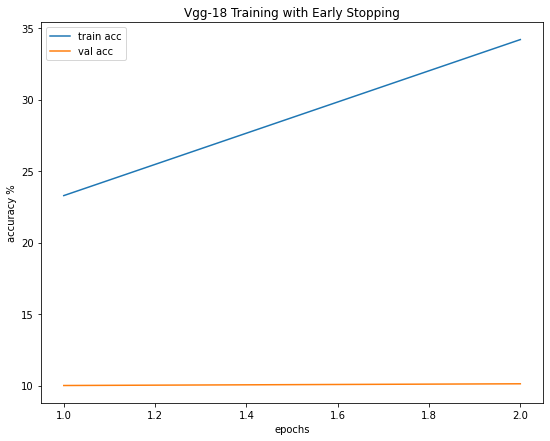

In [80]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history.keys()), [training_history[k]['acc'] for k in training_history.keys()], label = 'train acc')
plt.plot(list(training_history.keys()), [training_history[k]['val_acc'] for k in training_history.keys()], label = 'val acc')
plt.xlabel("epochs")
plt.ylabel("accuracy %")
plt.legend(loc = 'best')
plt.title("Vgg-18 Training with Early Stopping")
plt.show()

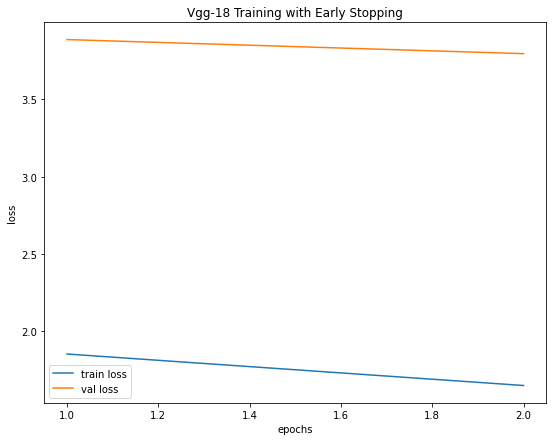

In [81]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history.keys()), [training_history[k]['loss'] for k in training_history.keys()], label = 'train loss')
plt.plot(list(training_history.keys()), [training_history[k]['val_loss'] for k in training_history.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("Vgg-18 Training with Early Stopping")
plt.show()

In [82]:
import pickle

In [83]:
with open("VGG18_dropout_earlystopping_training_history.pkl", "wb") as file:
    pickle.dump(training_history, file)

In [84]:
# Save trained weights-
# torch.save(model.state_dict(), 'VGG18_trained_weights.pth')

In [85]:
del model

### Train model with _learning rate scheduler_

- Training dataset = 50000, batch size = 128, number of training steps/iterations = 50000 / 128 = 391

- Initial learning rate warmup: 391 x 10 = 3910 steps or, 10 epochs at LR = 0.1

- Until 25th epoch or, 9775 steps use LR = 0.1

- From 26th epoch until 40th epoch or, 15640 steps use LR = 0.01

- From 41st epoch until 50th epoch or, 19550 steps use LR = 0.001

- From 51st epoch until 60th epoch use LR = 0.0001

In [86]:
# Initialize VGG-18 CNN model-
model = nn.Sequential(
    VGGBlock(input_channels = 3, num_channels = 64, dropout = 0.0),
    VGGBlock(input_channels = 64, num_channels = 128, dropout = 0.2),
    VGGBlock(input_channels = 128, num_channels = 256, use_extra_conv = True, dropout = 0.3),
    VGGBlock(input_channels = 256, num_channels = 512, use_extra_conv = True, dropout = 0.3),
    VGGBlock(input_channels = 512, num_channels = 512, use_extra_conv = True, dropout = 0.3),
    nn.Flatten(),
    nn.Linear(in_features = 512, out_features = 256),
    nn.Dropout(p = 0.3),
    nn.ReLU(),
    nn.Linear(in_features = 256, out_features = 10)
    )


In [87]:
# Place model on GPU-
model.to(device)

Sequential(
  (0): VGGBlock(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (dropout): Dropout(p=0.0, inplace=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): VGGBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (dropout): Dropout(p=0.2, inplace=False)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(128, eps=1e-05, momentu

In [88]:
# Load randomly initialised weights-
model.load_state_dict(torch.load('VGG18_random_weights_dropouts.pth'))

<All keys matched successfully>

In [89]:
boundaries = [9775, 15640, 19550]
values = [0.1, 0.01, 0.001, 0.0001]

In [90]:
# Define loss function and optimizer-
loss = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.0, momentum = 0.9, weight_decay = 5e-4)

In [91]:
# Sanity check-
optimizer.param_groups[0]['lr']

0.0

In [92]:
def decay_function(step, boundaries = [9775, 15640, 19550], values = [0.1, 0.01, 0.001, 0.0001]):
    '''
    1 epoch has 391 steps/iterations using batch size used above.
    
    Until 25th epochs, or 25 x 391 = 9775 steps, use lr = 0.1
    From 26th epoch until 40th epoch, or 15640 steps use LR = 0.01
    From 41st epoch until 50th epoch or, 19550 steps use LR = 0.001
    From 51st epoch until 60th epoch use LR = 0.0001
    '''
    
    for idx, bound in enumerate(boundaries):
        if step < bound:
            return values[idx]

    return values[-1]


In [93]:
"""
def decay_function(step, boundaries = [15640, 19550], values = [0.01, 0.001, 0.0001]):
    '''
    1 epoch has 391 steps/iterations using batch size used above.
    
    Until 40 epochs, or 40 x 391 = 15640 steps, use lr = 0.01
    Until 50 epochs, or 50 x 391 = 19550 steps, use lr = 0.001
    
    For any remaining steps, use lr = 0.0001
    '''
    
    for idx, bound in enumerate(boundaries):
        if step < bound:
            return values[idx]

    return values[-1]
"""

"\ndef decay_function(step, boundaries = [15640, 19550], values = [0.01, 0.001, 0.0001]):\n    '''\n    1 epoch has 391 steps/iterations using batch size used above.\n    \n    Until 40 epochs, or 40 x 391 = 15640 steps, use lr = 0.01\n    Until 50 epochs, or 50 x 391 = 19550 steps, use lr = 0.001\n    \n    For any remaining steps, use lr = 0.0001\n    '''\n    \n    for idx, bound in enumerate(boundaries):\n        if step < bound:\n            return values[idx]\n\n    return values[-1]\n"

In [94]:
# decay_function(step = 2, boundaries = [0, 2, 4, 6, 8, 10], values = [10, 15, 20, 30, 40, 50, 60])

In [95]:
class schedule():

    def __init__(self, initial_learning_rate = 0.1, warmup_steps = 1000, decay_func = None):
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.decay_func = decay_func
        self.warmup_step_size = initial_learning_rate/warmup_steps
        self.current_lr = 0

    def get_lr(self, step):
        if step == 0:
            return self.current_lr
        elif step <= self.warmup_steps:
            self.current_lr+=self.warmup_step_size
            return self.current_lr
        elif step > self.warmup_steps:
            if self.decay_func:
                return self.decay_func(step)
        else:
            return self.current_lr


In [96]:
# 391 x 10 = 3910 steps (or, 10 epochs) is learning rate warmup
custom_lr_scheduler = schedule(
    initial_learning_rate = 0.1, warmup_steps = 3910,
    decay_func = decay_function
)

In [97]:
step = 0

In [98]:
def train_model_progress(model, train_loader):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0
    
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = loss(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            global step
            optimizer.param_groups[0]['lr'] = custom_lr_scheduler.get_lr(step)

            step += 1
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.cpu().numpy()
    


In [99]:
def test_model_progress(model, test_loader):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                
                # Set model to evaluation mode-
                model.eval()
            
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.cpu().numpy()


In [100]:
training_history_lr_scheduler = {}

In [101]:
# Initialize parameters for Early Stopping manual implementation-
best_val_loss = 100
loc_patience = 0

In [102]:
for epoch in range(num_epochs):

    train_loss, train_acc = train_model_progress(model, train_loader)
    val_loss, val_acc = test_model_progress(model, test_loader)
    
    print(f"\nepoch: {epoch + 1} training loss = {train_loss:.4f}, "
          f"training accuracy = {train_acc:.2f}%, val_loss = {val_loss:.4f}"
          f", val_accuracy = {val_acc:.2f}% & "
          f"LR = {optimizer.param_groups[0]['lr']:.4f}\n")
    
    training_history_lr_scheduler[epoch + 1] = {
        'loss': train_loss, 'acc': train_acc,
        'val_loss': val_loss, 'val_acc': val_acc,
        'lr': optimizer.param_groups[0]['lr']
    }

    
    # Save best weights achieved until now-
    if (val_loss < best_val_loss):    
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = val_loss

        print(f"Saving model with lowest val_loss = {val_loss:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "VGG18_best_model.pth")
    


Validation: : 100%|██████████| 79/79 [00:02<00:00, 37.61batch/s, val_acc=10, val_loss=3.05]   



epoch: 1 training loss = 2.1178, training accuracy = 15.91%, val_loss = 3.0515, val_accuracy = 10.00% & LR = 0.0100

Saving model with lowest val_loss = 3.0515



Validation: : 100%|██████████| 79/79 [00:02<00:00, 36.52batch/s, val_acc=10, val_loss=3.99]   


epoch: 2 training loss = 1.8903, training accuracy = 21.44%, val_loss = 3.9874, val_accuracy = 10.00% & LR = 0.0200



In [103]:
# Save model from last training epoch-
# torch.save(model.state_dict(), "VGG18_last_epoch_model.pth")

In [104]:
'''
# Sanity check- Load model from before-
best_model = nn.Sequential(
    VGGBlock(input_channels = 3, num_channels = 64),
    VGGBlock(input_channels = 64, num_channels = 128),
    VGGBlock(input_channels = 128, num_channels = 256, use_extra_conv = True),
    VGGBlock(input_channels = 256, num_channels = 512, use_extra_conv = True),
    VGGBlock(input_channels = 512, num_channels = 512, use_extra_conv = True),
    nn.Flatten(),
    nn.Linear(in_features = 512, out_features = 256),
    nn.Linear(in_features = 256, out_features = 10)
    )
'''

'\n# Sanity check- Load model from before-\nbest_model = nn.Sequential(\n    VGGBlock(input_channels = 3, num_channels = 64),\n    VGGBlock(input_channels = 64, num_channels = 128),\n    VGGBlock(input_channels = 128, num_channels = 256, use_extra_conv = True),\n    VGGBlock(input_channels = 256, num_channels = 512, use_extra_conv = True),\n    VGGBlock(input_channels = 512, num_channels = 512, use_extra_conv = True),\n    nn.Flatten(),\n    nn.Linear(in_features = 512, out_features = 256),\n    nn.Linear(in_features = 256, out_features = 10)\n    )\n'

In [105]:
# best_model.load_state_dict(torch.load('VGG18_best_model.pth'))

In [106]:
# Place model on GPU-
# best_model.to(device)

In [107]:
# val_loss, val_acc = test_model_progress(best_model, test_loader)

In [108]:
# print(f"VGG-18 'best' model metrics: val_loss = {val_loss:.4f} & val_acc = {val_acc:.2f}%")

In [109]:
# del best_model

In [110]:
'''
# Sanity check- Load model from before-
trained_model = nn.Sequential(
    VGGBlock(input_channels = 3, num_channels = 64),
    VGGBlock(input_channels = 64, num_channels = 128),
    VGGBlock(input_channels = 128, num_channels = 256, use_extra_conv = True),
    VGGBlock(input_channels = 256, num_channels = 512, use_extra_conv = True),
    VGGBlock(input_channels = 512, num_channels = 512, use_extra_conv = True),
    nn.Flatten(),
    nn.Linear(in_features = 512, out_features = 256),
    nn.Linear(in_features = 256, out_features = 10)
    )
'''

'\n# Sanity check- Load model from before-\ntrained_model = nn.Sequential(\n    VGGBlock(input_channels = 3, num_channels = 64),\n    VGGBlock(input_channels = 64, num_channels = 128),\n    VGGBlock(input_channels = 128, num_channels = 256, use_extra_conv = True),\n    VGGBlock(input_channels = 256, num_channels = 512, use_extra_conv = True),\n    VGGBlock(input_channels = 512, num_channels = 512, use_extra_conv = True),\n    nn.Flatten(),\n    nn.Linear(in_features = 512, out_features = 256),\n    nn.Linear(in_features = 256, out_features = 10)\n    )\n'

In [111]:
# trained_model.load_state_dict(torch.load('VGG18_last_epoch_model.pth'))

In [112]:
# Place model on GPU-
# trained_model.to(device)

In [113]:
# val_loss, val_acc = test_model_progress(trained_model, test_loader)

In [114]:
# print(f"VGG-18 trained model metrics: val_loss = {val_loss:.4f} & val_acc = {val_acc:.2f}%")

In [115]:
# del trained_model

In [116]:
# Sanity check-
training_history_lr_scheduler.keys()

dict_keys([1, 2])

In [117]:
training_history_lr_scheduler[12].keys()

KeyError: 12

In [118]:
import pickle

In [119]:
# Save training metrics as Python3 history for later analysis-
with open("VGG18_dropout_training_history_lr_scheduler.pkl", "wb") as file:
    pickle.dump(training_history_lr_scheduler, file)

### Training Visualizations

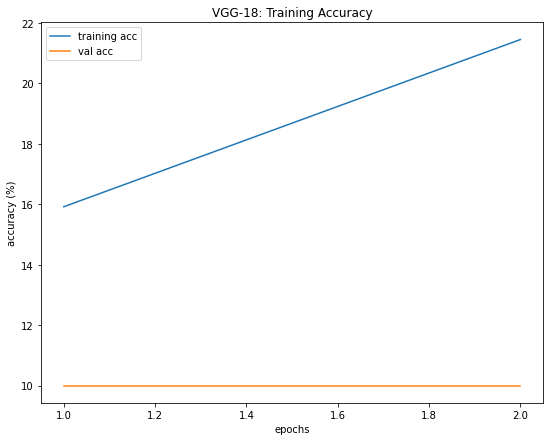

In [120]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['acc'] for k in training_history_lr_scheduler.keys()], label = 'training acc')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_acc'] for k in training_history_lr_scheduler.keys()], label = 'val acc')
plt.title("VGG-18: Training Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(loc = 'best')
plt.show()

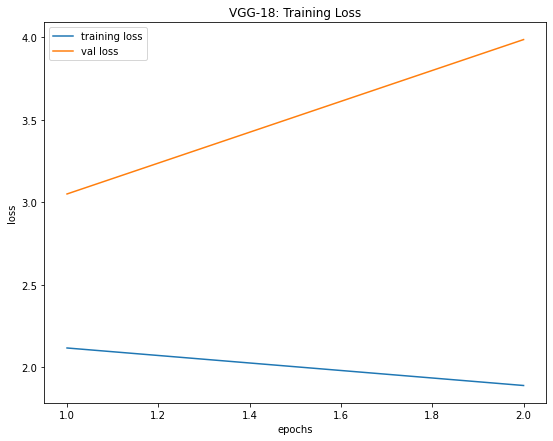

In [121]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['loss'] for k in training_history_lr_scheduler.keys()], label = 'training loss')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_loss'] for k in training_history_lr_scheduler.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("VGG-18: Training Loss")
plt.show()

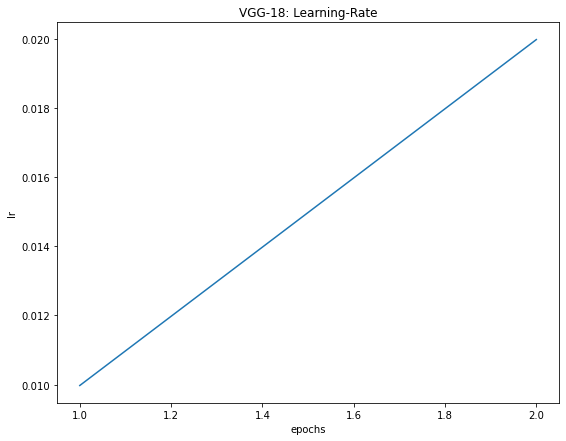

In [122]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['lr'] for k in training_history_lr_scheduler.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("VGG-18: Learning-Rate")
plt.show()